<a href="https://colab.research.google.com/github/adrian-valente/XAI_course_labs/blob/main/lab4_causal_scrubbing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DISCLAIMER: this notebook is mostly reorganized from the notebook causal_tracing.ipynb available in the ROME repository [here](https://github.com/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb). Full credit for any code here goes to Kevin Meng & colleagues.

We encourage you to try the method with different sets of sentences, varying the "subjects" and even the languages, and checking the consistency of the identified critical layers.

# Loading some stuff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict, OrderedDict
import contextlib
import re
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [ ]:
from util import nethook  # We will simply import this module from the rome library (contains hooks)

# Load and test the GPT2 model

In [ ]:
# Here we load the pretrained GPT2-XL model with its associated tokenizer

model_name = 'gpt2-xl'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Description of the model architecture
model.eval().cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [ ]:
# Useful construct to extract the main layers in the model
# (works for GPT and Eleuther models)
layer_names = [
    n
    for n, m in model.named_modules()
    if re.match(r"^(transformer|gpt_neox)\.(h|layers)\.\d+$", n)
]
layer_names

['transformer.h.0',
 'transformer.h.1',
 'transformer.h.2',
 'transformer.h.3',
 'transformer.h.4',
 'transformer.h.5',
 'transformer.h.6',
 'transformer.h.7',
 'transformer.h.8',
 'transformer.h.9',
 'transformer.h.10',
 'transformer.h.11',
 'transformer.h.12',
 'transformer.h.13',
 'transformer.h.14',
 'transformer.h.15',
 'transformer.h.16',
 'transformer.h.17',
 'transformer.h.18',
 'transformer.h.19',
 'transformer.h.20',
 'transformer.h.21',
 'transformer.h.22',
 'transformer.h.23',
 'transformer.h.24',
 'transformer.h.25',
 'transformer.h.26',
 'transformer.h.27',
 'transformer.h.28',
 'transformer.h.29',
 'transformer.h.30',
 'transformer.h.31',
 'transformer.h.32',
 'transformer.h.33',
 'transformer.h.34',
 'transformer.h.35',
 'transformer.h.36',
 'transformer.h.37',
 'transformer.h.38',
 'transformer.h.39',
 'transformer.h.40',
 'transformer.h.41',
 'transformer.h.42',
 'transformer.h.43',
 'transformer.h.44',
 'transformer.h.45',
 'transformer.h.46',
 'transformer.h.47']

In [ ]:
# Here we define a few functions that are useful to run the model from text

def make_inputs(tokenizer, prompts, device="cuda"):
    """
    Generate tokenized inputs for a batch (a list of prompts).
    """
    # First we run the tokenizer
    token_lists = [tokenizer.encode(p) for p in prompts]

    # Then pad the inputs to longest prompt length
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]

    # Return tokenized inputs and attention masks
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )


def predict_from_input(model, inp):
    """
    Run model on batch of tokenized inputs.
    """
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    p, preds = torch.max(probs, dim=1)
    return preds, p


def predict_token(tokenizer, model, prompts, return_p=False, decode=True):
    """
    Run the model and predict next token
    """
    inp = make_inputs(tokenizer, prompts)           # tokenize and pad inputs
    result, p = predict_from_input(model, inp)       # Run model
    if decode:
      result = [tokenizer.decode(c) for c in result]   # Decode output tokens
    if return_p:
        result = (result, p)
    return result

# Try it out
predict_token(tokenizer, model, ["The Eiffel tower is in the city of"], return_p=True)

([' Paris'], tensor([0.5969], device='cuda:0', grad_fn=<MaxBackward0>))

Now, we will write the function that performs the patching for a specific layer, and when scrambling a certain set of tokens (the trace_with_patch function).

In [ ]:
# Utility function to get the layer name associated with a particular number
def layername(model, num, kind=None):
    if hasattr(model, "transformer"):
        if kind == "embed":
            return "transformer.wte"
        return f'transformer.h.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "gpt_neox"):
        if kind == "embed":
            return "gpt_neox.embed_in"
        if kind == "attn":
            kind = "attention"
        return f'gpt_neox.layers.{num}{"" if kind is None else "." + kind}'
    assert False, "unknown transformer structure"


# Small utility
def untuple(x):
    return x[0] if isinstance(x, tuple) else x


"""
The function below contains the important logic for patching.
It relies on a context manager object TraceDict that is very similar in spirit
to the SilenceHook of lab 3. Here is its documentation reproduced:

    class TraceDict:
    To retain the output of multiple named layers during the computation
    of the given network:

        with TraceDict(net, ['layer1.name1', 'layer2.name2']) as ret:
            _ = net(inp)
            representation = ret['layer1.name1'].output

    If edit_output is provided, it should be a function that takes
    two arguments: output, and the layer name; and then it returns the
    modified output.
"""


def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) tuples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
):
    prng = np.random.RandomState(1)  # For reproducibility, use pseudorandom noise

    # We first retrieve the states in the non-corrupted run
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    # Define the model-patching rule. (that is a hook function)
    def patch_rep(x, layer):

        # Particular case of the embedding layer
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            # Note that x is a batch, and we corrupt subject tokens everywhere except
            # on the first batch input (which will be the clean run)
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x

        # Then we corrupt layers in the patch spec
        if layer not in patch_spec:
            return x

        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens. Remember the clean run is in the first element along
        # the batch dimension.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # We run the model with editing hooks, one on the embedding layer
    # that will scramble the subject tokens, one on the patch_spec layers that
    # will
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]
    return probs

In [ ]:
def find_token_range(tokenizer, token_array, substring):
    toks = [tokenizer.decode(w) for w in token_array]
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)

In [ ]:
# Define a prompt and a subject to "meddle with"
prompt = "The Eiffel Tower is in the city of"
subject = 'The Eiffel Tower'

['The', ' E', 'iff', 'el', ' Tower', ' is', ' in', ' the', ' city', ' of']
Predicted answer:  Paris


[Text(0, 0.5, 'The'),
 Text(0, 1.5, ' E'),
 Text(0, 2.5, 'iff'),
 Text(0, 3.5, 'el'),
 Text(0, 4.5, ' Tower'),
 Text(0, 5.5, ' is'),
 Text(0, 6.5, ' in'),
 Text(0, 7.5, ' the'),
 Text(0, 8.5, ' city'),
 Text(0, 9.5, ' of')]

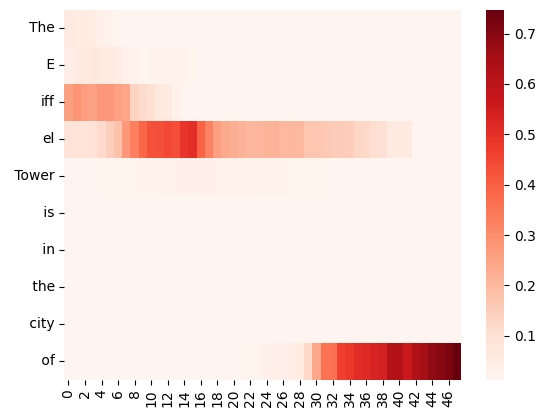

In [ ]:
# Here we do the basic preprocessing:

# Get the tokens of the prompt, and see what they correspond to
inp_tokens = make_inputs(tokenizer, [prompt])['input_ids'][0]
inp_tokens_w = [tokenizer.decode(w) for w in inp_tokens]
print(inp_tokens_w)

# Put together a batch
samples = 10
inp = make_inputs(tokenizer, [prompt] * (samples + 1))

# Get original output
original_answer_i, original_p = predict_from_input(model, make_inputs(tokenizer, [prompt]))
print(f"Predicted answer: {tokenizer.decode(original_answer_i)}")

# Get positions of the subject
e_range = find_token_range(tokenizer, inp_tokens, subject)

# Apply patching to the subject tokens, for each layer
table = []
for tnum in range(inp['input_ids'].shape[1]):
    row = []
    for layer in layer_names:
        r = trace_with_patch(
            model,
            inp,
            [(tnum, layer)],
            original_answer_i,
            tokens_to_mix=e_range
        )
        row.append(r)
    table.append(torch.stack(row))
table = torch.stack(table).squeeze()


# Visualize results
fig, ax = plt.subplots()
sns.heatmap(table.cpu().numpy(), cmap='Reds', ax=ax)
ax.set_yticklabels(inp_tokens_w, rotation=0)

In [ ]:
original_answer_i

tensor([6342], device='cuda:0')